In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import polars as pl
from datetime import timedelta
import datetime 
import json 
import toml
import holidays
import sys

features = toml.load(r'C:\Users\N000193384\Documents\sncf_project\sncf_playground\data\features.toml')
times_cols = features['times_cols']
macro_horizon = features['MACRO_HORIZON']
p = Path(features['ABS_DATA_PATH'])
sys.path.insert(1, p)

from src.analysis.describe import describe_timeseries
from src.preprocessing.times import from_day_to_time_fe, get_covid_table, symmetrical_days_until_event
from src.preprocessing.quality import trim_timeseries, minimum_length_uid
from src.preprocessing.lags import reference_shift_from_day, pl_compute_lagged_features, pl_compute_moving_features
from src.analysis.metrics import display_metrics
from src.models.forecast.direct import DirectForecaster

# metrics of the competition.
from sklearn.metrics import mean_absolute_percentage_error
from src.project_utils import forecast_to_submit,load_data
from src.preprocessing.validation import freeze_validation_set
from src.models.lgb_wrapper import GBTModel
from src.preprocessing.scale import PanelStandardScaler
from src.project_utils import submit_fcst

ts_uid = features["ts_uid"]
date_col = features['date_col']
y = features['y']
submit = False 
flist = features["flist"]
long_horizon = np.arange(macro_horizon)
chains = np.array_split(long_horizon, 6)
exog = ["job", "ferie", "vacances"] + times_cols

with open('data/params.json', 'rb') as stream:
    params_q = json.load(stream)

in_dt = datetime.date(2019, 12, 31)

In [115]:
country_holidays = holidays.France(years=np.arange(2015, 2024))
holiday_list = [{"date": date, "holiday": name} for date, name in sorted(country_holidays.items())]
holiday_df = pd.DataFrame(holiday_list).assign(year=lambda x : pd.to_datetime(x['date']).dt.year)
covid_df = get_covid_table(2015, 2024)
covid_df = pl.from_pandas(covid_df).with_columns(pl.col('date').cast(pl.Date).alias('date'))


df_dates = pd.DataFrame({'date':  pd.date_range(start=datetime.datetime(2015, 1, 1), end=datetime.datetime(2024, 12, 31))})

# Add columns for each event
event_names = holiday_df['holiday'].unique()
for event_name in event_names:
    event_dates = holiday_df[holiday_df['holiday'] == event_name]['date'].tolist()
    event_dates = [pd.to_datetime(x) for x in event_dates]
    df_dates[event_name] = df_dates['date'].apply(lambda x: symmetrical_days_until_event(x, event_dates))

df_dates = pl.from_pandas(df_dates).with_columns(pl.col('date').cast(pl.Date).alias('date'))

holidays_fe = list(filter(lambda x : "date" not in x, df_dates.columns))
covid_fe = list(filter(lambda x : "date" not in x, covid_df.columns))

exog += holidays_fe
exog += covid_fe
# df_dates.tail()

In [116]:
train_data, test_data, submission = load_data(p)

# sncf strike | 2019-12-01 to 2021-11-01

test_data = (test_data
            .pipe(from_day_to_time_fe, time="date", frequency="day")
            .join(df_dates, how="left", on=['date'])
            .join(covid_df, how="left", on=["date"])
)


train_data = (train_data
              .pipe(trim_timeseries, target="y", uid="station", time="date")
              # .with_columns(pl.col(y).log1p().cast(pl.Float32).alias(y))
              .pipe(from_day_to_time_fe, time="date", frequency="day")
              .join(df_dates, how="left", on=['date'])
              .join(covid_df, how="left", on=["date"])
              .filter(
                  (pl.col('date')>= in_dt) & 
                  (pl.col('date') != pl.datetime(2019, 12, 1)) & 
                  (pl.col('date') != pl.datetime(2021, 11, 1))
                  )
)

good_ts = minimum_length_uid(
    train_data,
    target=y, 
    uid=ts_uid,
    time="date", 
    min_length=364*2
)

train_data = train_data.filter(pl.col(ts_uid).is_in(good_ts))
train_set, validation_set = freeze_validation_set(df=train_data, ts_uid=ts_uid, date=date_col, target=y, val_size=macro_horizon)
# train_set.head()

In [4]:
from statsmodels.tsa.stattools import pacf
series = train_data.groupby('date').agg(pl.col('y').sum()).sort(by="date").select(pl.col('y').cast(pl.Int32)).to_numpy().flatten()
pacf_values = pacf(series, nlags=364)

# Identify lags with significant PACF values
threshold = 1.96 / np.sqrt(len(series))
significant_lags = [lag for lag, value in enumerate(pacf_values) if abs(value) > threshold]


C:\Users\N000193384\AppData\Local\Temp\ipykernel_52260\1121667549.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  series = train_data.groupby('date').agg(pl.col('y').sum()).sort(by="date").select(pl.col('y').cast(pl.Int32)).to_numpy().flatten()


In [128]:
import torch
from torch import nn

from src.preprocessing.polars.lags import compute_autoreg_features

for key in autoreg_dict.keys():
    autoreg_dict[key]["horizon"] = autoreg_dict[key]["horizon"](181)
    autoreg_dict[key]["shifts"] = autoreg_dict[key]["shifts"](181)
    autoreg_dict[key]["lags"] = autoreg_dict[key]["lags"](181)

train_data = compute_autoreg_features(train_data,
                target_col="y",
                date_str="date",
                auto_reg_params=autoreg_dict,
            )


train_set, validation_set = freeze_validation_set(
    df=train_data,
    ts_uid=ts_uid, 
    date=date_col, 
    target=y, 
    val_size=macro_horizon
    )


In [132]:
lags_fe = list(filter(lambda x : "ar_" in x, train_set.columns))

In [147]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class FirstModel(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, out_dim)
        self.SELU = nn.SELU()
        self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        x = self.linear1(x)
        x = self.SELU(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.SELU(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x
    
model = FirstModel(in_dim=len(lags_fe)+len(exog)).to(device)
learning_rate = 0.003
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# Number of epochs
epochs = 10

# Send data to the device
train_data = train_set.fill_null(strategy="zero").select(lags_fe+exog).to_torch(dtype=pl.Float32)
y_train_data = train_set.select('y').to_torch(dtype=pl.Float32)

val_data = validation_set.fill_null(strategy="zero").select(lags_fe+exog).to_torch(dtype=pl.Float32)
y_val_data = validation_set.select('y').to_torch(dtype=pl.Float32)

type(train_data), type(y_train_data)

x_train, x_valid = train_data.to(device), val_data.to(device)
y_train, y_valid = y_train_data.to(device), y_val_data.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    y_hat = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    print(y_hat)

tensor([ 2.7989, 11.6790,  9.5630,  ..., 10.2524, 27.9617, 85.1039],
       grad_fn=<SqueezeBackward0>)
tensor([  0.6115,   7.7897,   8.3699,  ...,  54.8611,  88.1544, 116.5990],
       grad_fn=<SqueezeBackward0>)
tensor([-3.4250, 17.7749, 21.1395,  ..., 38.0062, 80.7637, 49.7806],
       grad_fn=<SqueezeBackward0>)
tensor([  1.0006,  18.2119,   4.7141,  ...,  -8.9299,  49.3294, -72.5730],
       grad_fn=<SqueezeBackward0>)
tensor([  2.3411,  25.8976,  17.2297,  ...,  30.3753,  88.5481, -17.7947],
       grad_fn=<SqueezeBackward0>)
tensor([ -1.6755,  15.4647,   3.4603,  ...,  38.3853, -46.1957,  23.8795],
       grad_fn=<SqueezeBackward0>)
tensor([-2.9442e+00,  1.5853e-02,  4.6127e+00,  ...,  1.6731e+01,
         1.7227e+02,  5.0045e+01], grad_fn=<SqueezeBackward0>)
tensor([ 0.4610, 21.0519,  6.2660,  ..., 66.3529, 88.4049, 21.5910],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.4236, 18.7818, 13.5323,  ..., 18.6991, 80.9563, 67.6160],
       grad_fn=<SqueezeBackward0>)
tensor([  2.314

In [142]:
torch.nn.SELU

tensor([[  nan,   nan,   nan,  ...,   35.,    0.,    0.],
        [  13.,   16.,   11.,  ...,    0.,    0.,    0.],
        [  78.,   70.,   15.,  ...,    0.,   11.,    0.],
        ...,
        [  nan,   nan,   nan,  ...,    0.,    0.,    0.],
        [ 967.,  536.,  612.,  ...,    0.,    0.,    0.],
        [1109.,  167.,  424.,  ...,    0.,    0.,   44.]])

# Direct ML Forecast

In [7]:
horizon = 181
lags = [x for x in significant_lags if x <= horizon]
win_list =  [ x for x in significant_lags if x % 7 == 0 and x <= horizon][1:] 

autoreg_dict = {
    ts_uid : {
        'groups' : ts_uid,
        'horizon': lambda horizon : np.int32(horizon),
        'wins' : np.array(win_list), 
        'shifts' : lambda horizon : np.int32([horizon, horizon+56]), 
        'lags' : lambda horizon : np.array(significant_lags) + horizon,
        'funcs' : np.array(flist)
    },
    "ts_uid_dow" : {
        'groups':[ts_uid, 'day_of_week'],
        'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
        'wins' : np.array([4, 12]), 
        'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1]), 
        'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
        'funcs' : np.array(flist)
    }
}

from src.models.scikit_wrapper import ScikitWrapper
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=-1)
rf_reg = ScikitWrapper(model=rf, params=None, features=None, categorical_features=[], weight=None)

lgb_m = GBTModel(params=params_q, 
                    early_stopping_value=200, 
                    features= None,
                    custom_loss="l1", 
                    categorical_features=[]
                    )


dir_forecaster = DirectForecaster(
    model=lgb_m,
    ts_uid=ts_uid,
    forecast_range=np.arange(horizon),
    target_str="y",
    date_str="date",
    exogs=exog,
    features_params=autoreg_dict,
    n_jobs=-1
)

#dir_forecaster.fit(train_data=train_data)
dir_forecaster.fit(train_data=train_data, strategy="global")
# 0.76 sans exog
# 0.6419 avec exog 
#  0.6649 sans holidays mais exog

# rmse wo log : 2336
# rmse wo log + covid : 2311.32
# best params = 2087
# [134]	valid_0's rmse: 2121.52

left_term = train_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(1).alias('train'))
right_term = test_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(0).alias('train'))
full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
del left_term, right_term

lgb_out = (dir_forecaster
            .predict(full_data)
            .filter(pl.col('train') == 0)
)

(test_data
 .select(['index', 'date', 'station']).join(
     lgb_out.select(['date', 'station', 'y_hat']), 
     how="left", on=['date', 'station']
     )
     .fill_null(0)
     .select(['index', 'y_hat'])
     .rename({"y_hat":"y"})
     ).write_csv('out/submit/local_lgb.csv')


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	valid_0's rmse: 2454.88


In [10]:
valid_out = dir_forecaster.valid.with_columns(pl.lit(
    dir_forecaster.model.predict(dir_forecaster.valid)
    ).alias('y_hat')
    )
print(dir_forecaster.evaluate())

     fname         rmse        bias     mape     wfiab         mae
0  default  2454.877638 -442.342983  2.36962  0.807678  835.600482


In [ ]:
'''import os
from typing import Dict, List

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def objective(
    trial: optuna.trial,
    train_data: pd.DataFrame,
    exog: List,
    seed: int = 12345,
):
    """_summary_

    Args:
        trial (optuna.trial): _description_
        train_x (pd.DataFrame): _description_
        test (pd.DataFrame): _description_
        features (List): _description_
        target (str, optional): _description_. Defaults to "".
        seed (int, optional): _description_. Defaults to 12345.

    Returns:
        _type_: _description_
    """
    optuna_params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": trial.suggest_categorical(
            "objective", ["regression", "huber", "regression_l1", "quantile"]
        ),
        "metric": trial.suggest_categorical("metric", ["rmse"]),
        "alpha": trial.suggest_categorical(
            "alpha",
            [0.5, 0.52, 0.55, 0.57, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.69, 0.7],
        ),
        "force_row_wise": trial.suggest_categorical("force_row_wise", [True, False]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=False),
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "sub_row": trial.suggest_categorical("sub_row", [0.6, 0.7, 0.8, 1.0]),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 4, log=True),
        "min_child_samples": trial.suggest_float(
            "min_child_samples", 20, 5000, log=False
        ),
        "num_iterations": trial.suggest_int(
            "n_estimators",
            200,
            3000,
        ),
        "num_leaves": trial.suggest_int("num_leaves", 25, 800),
        "max_bins": trial.suggest_int("max_bins", 24, 1000),
        "min_data_in_bin": trial.suggest_int("min_data_in_bin", 25, 1000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 1000),
        "feature_fraction_seed": trial.suggest_categorical(
            "feature_fraction_seed", [seed]
        ),
        "bagging_seed": trial.suggest_categorical("bagging_seed", [seed]),
        "seed": trial.suggest_categorical("seed", [seed]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }

    horizon = 181
    lags = [x for x in significant_lags if x <= horizon]
    win_list =  [ x for x in significant_lags if x % 7 == 0 and x <= horizon][1:] 

    autoreg_dict = {
        ts_uid : {
            'groups' : ts_uid,
            'horizon': lambda horizon : np.int32(horizon),
            'wins' : np.array(win_list), 
            'shifts' : lambda horizon : np.int32([horizon, horizon+28, horizon+56]), 
            'lags' : lambda horizon : np.array(significant_lags) + horizon,
            'funcs' : np.array(flist)
        },
        "ts_uid_dow" : {
            'groups':[ts_uid, 'day_of_week'],
            'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
            'wins' : np.array([4, 8, 12, 16, 20]), 
            'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1, np.ceil(horizon /7) + 4]), 
            'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
            'funcs' : np.array(flist)
        }
    }


    effect_m = GBTModel(params=optuna_params, 
                        early_stopping_value=200, 
                        features= None,
                        custom_loss=optuna_params["objective"], 
                        categorical_features=[]
                        )


    dir_forecaster = DirectForecaster(
        model=effect_m,
        ts_uid=ts_uid,
        forecast_range=np.arange(horizon),
        target_str="y",
        date_str="date",
        exogs=exog,
        features_params=autoreg_dict
    )

    dir_forecaster.fit(train_data=train_data)
    return dir_forecaster.evaluate()["mae"].values[0]


def parameters_tuning(
    initial_params: Dict,
    tuning_objective,
    n_trials: int = 25,
    njobs: int = -1,
):
    """parameter for tuning over sudy

    Args:
        tuning_objective (_type_): _description_
        n_trials (int, optional): _description_. Defaults to 25.

    Returns:
        _type_: _description_

    example :

    func = lambda trial: objective(trial=trial,
                                    train_x=train_x,
                                    test=residualised_test,
                                    covariates=covariates,
                                    target=y,
                                    seed=12345
                                    )
    study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=25, initial_params={})
        print(best_params)
        print(study_df)
        study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)
    """
    study = optuna.create_study(direction="minimize")
    # study.enqueue_trial(initial_params)
    study.optimize(tuning_objective, n_trials=n_trials, n_jobs=njobs)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    study_df = study.trials_dataframe()
    return study_df, study.best_params


func = lambda trial: objective(trial=trial,
                                train_data=train_data,
                                exog=exog,
                                seed=12345
                                )
study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=30, initial_params={}, njobs=10)
print(best_params)
print(study_df)
study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)'''

'import os\nfrom typing import Dict, List\n\nimport lightgbm as lgb\nimport numpy as np\nimport optuna\nimport pandas as pd\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n\ndef objective(\n    trial: optuna.trial,\n    train_data: pd.DataFrame,\n    exog: List,\n    seed: int = 12345,\n):\n    """_summary_\n\n    Args:\n        trial (optuna.trial): _description_\n        train_x (pd.DataFrame): _description_\n        test (pd.DataFrame): _description_\n        features (List): _description_\n        target (str, optional): _description_. Defaults to "".\n        seed (int, optional): _description_. Defaults to 12345.\n\n    Returns:\n        _type_: _description_\n    """\n    optuna_params = {\n        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),\n        "objective": trial.suggest_categorical(\n            "objective", ["regression", "huber", "regression_l1", "quantile"]\n        ),\n        

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class ZeroBalance_RMSE(nn.Module):
    def __init__(self, penalty=1.12):
        super().__init__()
        self.penalty = penalty
        
    def forward(self, y_pred, y_true):
        y_pred = y_pred.squeeze()
        y_true = torch.FloatTensor(y).to(device)
        sq_error = torch.where(y_true==0, (y_true-y_pred)**2, self.penalty*(y_true-y_pred)**2)
        return torch.sqrt(torch.mean(sq_error))

class RMSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        y_pred = y_pred.squeeze()
        y_true = torch.FloatTensor(y).to(device)
        return torch.sqrt(self.mse(y_pred, y_true))    
    

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class LinearBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.block = nn.Sequential(
                            nn.Linear(inp, out),
#                             nn.LeakyReLU(),
                            nn.ReLU(),
#                             nn.Tanh(),
        )
    
    def forward(self, x):
        return self.block(x)

class TabularNet(nn.Module):
    def __init__(self, emb_dims, n_cont, device="cpu"):
        super().__init__()
        self.device = device

        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        n_embs = sum([y for x, y in emb_dims])
        
        self.n_embs = n_embs
        self.n_cont = n_cont
        inp_dim = n_embs + n_cont
        self.inp_dim = inp_dim
        
        hidden_dim = 200

        self.fn = nn.Sequential(
                 LinearBlock(inp_dim, hidden_dim),
                 LinearBlock(hidden_dim, hidden_dim//2),
                 LinearBlock(hidden_dim//2, hidden_dim//4),
                 LinearBlock(hidden_dim//4, hidden_dim//8),
        )          
        
        self.out = nn.Linear(hidden_dim//8, 1)

        self.fn.apply(init_weights)
        self.out.apply(init_weights)
        

    def encode_and_combine_data(self, cont_data, cat_data):
        xcat = []
        print(self.emb_layers, cat_data.size())
        for k, el in enumerate(self.emb_layers):
            print(k, el, cat_data.size())
            xcat.append(el(cat_data[:, :, k]))
        xcat = torch.cat(xcat, 1)
        x = torch.cat([xcat, cont_data], 1)
        return x   
    
    def forward(self, cont_data, cat_data):
        cont_data = cont_data.to(self.device)
        cat_data = cat_data.to(self.device)
        inputs = self.encode_and_combine_data(cont_data, cat_data)
        x = self.fn(inputs)
        x = self.out(x)
        return x
    

uniques = [full_data.select(pl.col(c).n_unique()).to_numpy()[0][0] for c in times_cols]
dims = [1]*len(uniques)
emb_dims = [(x, y) for x, y in zip(uniques, dims)]
n_cont = len(features)
# device = torch.device('cuda')
device = torch.device('cpu')
model = TabularNet(emb_dims, n_cont).to(device)
epochs = 45
lr = 0.0002
criterion = ZeroBalance_RMSE()
torch.manual_seed(42)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
                    optimizer, [20, 35, 40], gamma=0.5, 
                    last_epoch=-1)

train_losses = []
val_losses = []

bs = 16
shuffle = True

class DataCLoader:
    def __init__(self, X, y, shuffle=True, batch_size=16, cat_cols=[]):
        self.X_cont = X["dense1"]
        self.X_cat = np.concatenate([X[k] for k in cat_cols], axis=1)
        self.y = y

        self.shuffle = shuffle
        self.batch_size =batch_size
        self.n_conts = self.X_cont.shape[1]
        self.len = self.X_cont.shape[0]
        n_batches, remainder = divmod(self.len, self.batch_size)
        
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
        self.remainder = remainder #for debugging
        
        self.idxes = np.array([i for i in range(self.len)])

    def __iter__(self):
        self.i = 0
        if self.shuffle:
            ridxes = self.idxes
            np.random.shuffle(ridxes)
            self.X_cat = self.X_cat[[ridxes]]
            self.X_cont = self.X_cont[[ridxes]]
            if self.y is not None:
                self.y = self.y[[ridxes]]
                
        return self

    def __next__(self):
        if self.i  >= self.len:
            raise StopIteration
            
        if self.y is not None:
            y = torch.FloatTensor(self.y[self.i:self.i+self.batch_size].astype(np.float32))
        else:
            y = None
            
        xcont = torch.FloatTensor(self.X_cont[self.i:self.i+self.batch_size])
        xcat = torch.LongTensor(self.X_cat[self.i:self.i+self.batch_size])
        
        batch = (xcont, xcat, y)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches  
    
def make_X(df, cat_cols, dense_cols):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(train_data.to_pandas().index, test_size=0.05, 
                                      random_state=42, shuffle=True)



valid = (make_X(validation_set, cat_cols=times_cols, dense_cols=holidays_fe), validation_set["y"])

X_train = make_X(train_set, cat_cols=times_cols, dense_cols=holidays_fe)
y_train = train_set["y"]

train_loader = DataCLoader(X_train, y_train.to_numpy(), cat_cols=times_cols, batch_size=bs, shuffle=shuffle)
val_loader = DataCLoader(valid[0], valid[1].to_numpy, cat_cols=times_cols, batch_size=bs, shuffle=shuffle)

for epoch in tqdm(range(epochs)):
    train_loss, val_loss = 0, 0

    #Training phase
    model.train()
    bar = tqdm(train_loader)
    
    for i, (X_cont, X_cat, y) in enumerate(bar):
        optimizer.zero_grad()
        out = model(X_cont, X_cat)
        loss = criterion(out, y)   
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_loss += loss.item()/len(train_loader)
            bar.set_description(f"{loss.item():.3f}")
    
    print(f"Running Train loss: {train_loss}")
    
    #Validation phase      
    with torch.no_grad():
        model.eval()
        for phase in ["train", "valid"]:
            rloss = 0
            if phase == "train":
                loader = train_loader
            else:
                loader = val_loader
            
            y_true = []
            y_pred = []
            
            for i, (X_cont, X_cat, y) in enumerate(loader):
                out = model(X_cont, X_cat)
                loss = criterion(out, y)
                rloss += loss.item()/len(loader)
                y_pred += list(out.detach().cpu().numpy().flatten())
                y_true += list(y.cpu().numpy())
                
            from sklearn.metrics import mean_squared_error
            rrmse = mean_squared_error(y_pred, y_true, squared=False)
            print(f"[{phase}] Epoch: {epoch} | Loss: {rloss:.4f} | RMSE: {rrmse:.4f}")
      
    train_losses.append(train_loss)    
    val_losses.append(rloss)        
    scheduler.step()

  0%|          | 0/45 [00:00<?, ?it/s]


ModuleList(
  (0): Embedding(53, 1)
  (1): Embedding(12, 1)
  (2): Embedding(31, 1)
  (3): Embedding(7, 1)
  (4): Embedding(4, 1)
  (5): Embedding(5, 1)
  (6): Embedding(2, 1)
) torch.Size([1, 377417, 7])
0 Embedding(53, 1) torch.Size([1, 377417, 7])


IndexError: index out of range in self

In [84]:
y

tensor([[ 354.,   68.,  136.,  ..., 5945., 3080., 1225.]])

In [ ]:
dir_forecaster = DirectForecaster(
    model=mlp,
    ts_uid=ts_uid,
    forecast_range=np.arange(horizon),
    target_str="y",
    date_str="date",
    exogs=exog,
    features_params=autoreg_dict
)


In [ ]:
validation = False
if not validation:
    left_term = train_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(1).alias('train'))
    right_term = test_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(0).alias('train'))
    full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
    del left_term, right_term
    lgb_out = (dir_forecaster
                .predict(full_data)
                .filter(pl.col('train') == 0)
    )
    # lgb_out = lgb_out.with_columns(np.expm1(lgb_out['y_hat']).alias('y_hat'))

else:
    valid_out = dir_forecaster.valid.with_columns(pl.lit(np.expm1(dir_forecaster.model.predict(dir_forecaster.valid))).alias('y_hat'))
    print(dir_forecaster.evaluate())
    
    full_data = pl.concat((train_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(1).alias('train')), 
                    test_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(0).alias('train'))), how="vertical_relaxed")

    lgb_out = dir_forecaster.predict(full_data).filter(pl.col('train') == 0)

    # lgb_out = lgb_out.with_columns(pl.lit(np.expm1(lgb_out['y_hat'])).alias('y_hat'))
    # submit
    direct_output = submit_fcst(test_data, lgb_out, ts_uid=ts_uid)
    direct_output.write_csv('out/submit/direct_forecasting.csv')

# Chain Forecast

running piece = array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2245]	valid_0's rmse: 1572.43


,fname,rmse,bias,mape,wfiab,mae
0,default,1572.433703,114.253739,0.471931,0.889002,485.695903


running piece = array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1515]	valid_0's rmse: 1847.16


,fname,rmse,bias,mape,wfiab,mae
0,default,1847.163773,-127.632027,1.234983,0.873755,582.214819


running piece = array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2333]	valid_0's rmse: 1959.16


,fname,rmse,bias,mape,wfiab,mae
0,default,1959.164163,-221.734939,1.288997,0.858635,665.148041


running piece = array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1489]	valid_0's rmse: 2002.01


,fname,rmse,bias,mape,wfiab,mae
0,default,2002.009883,-297.061076,1.379273,0.848731,714.067538


running piece = array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	valid_0's rmse: 2209.82


,fname,rmse,bias,mape,wfiab,mae
0,default,2209.822869,-379.207131,2.056675,0.829701,755.878645


running piece = array([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180])


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[279]	valid_0's rmse: 2440.83


,fname,rmse,bias,mape,wfiab,mae
0,default,2440.832539,-475.877566,2.366538,0.807446,836.609105


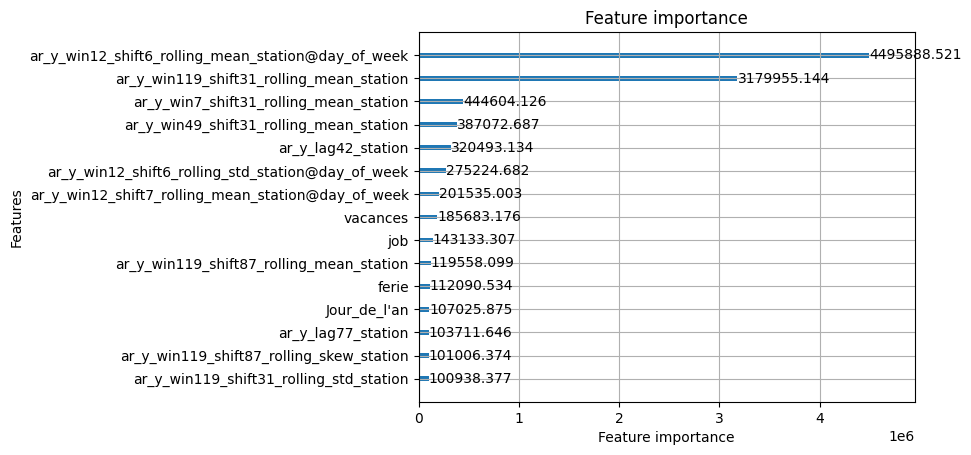

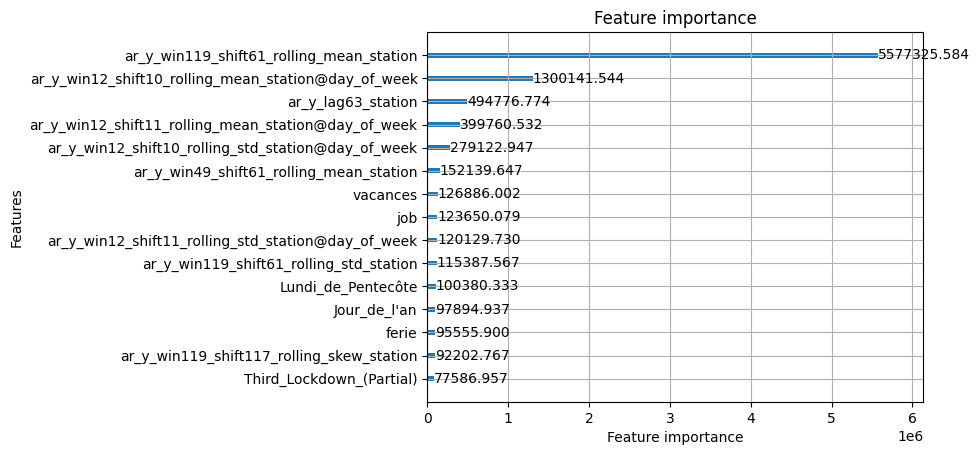

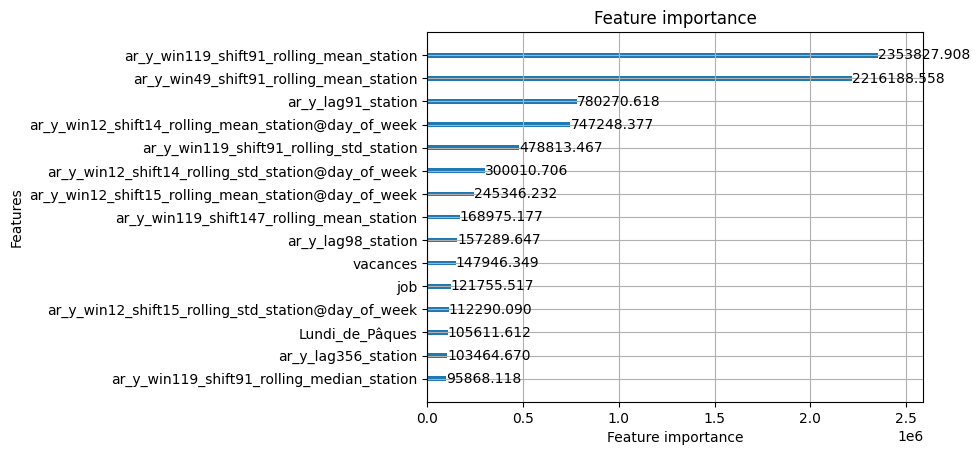

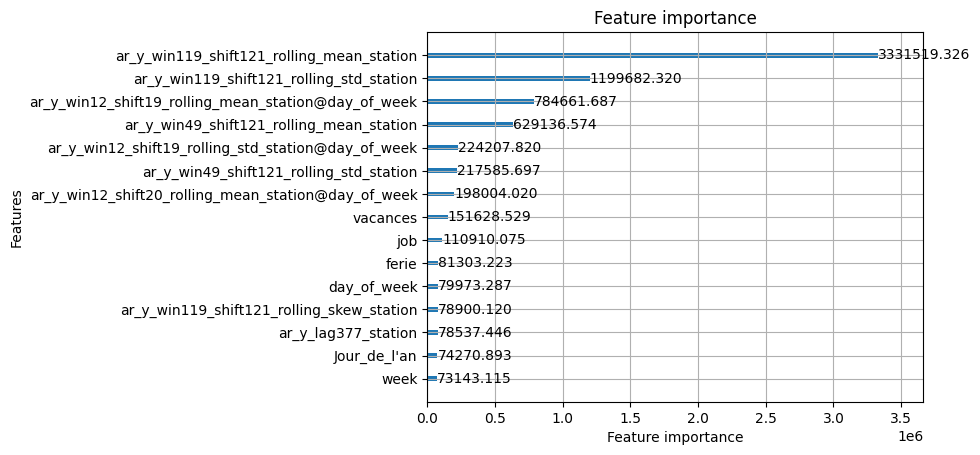

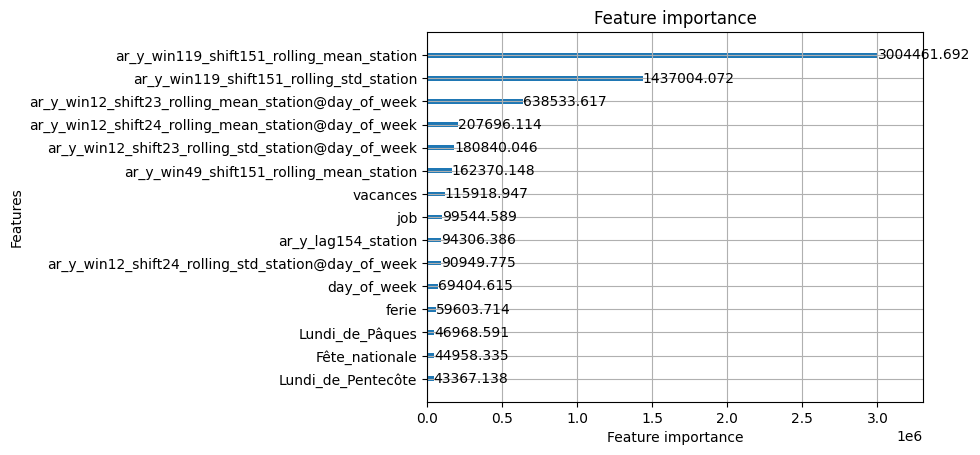

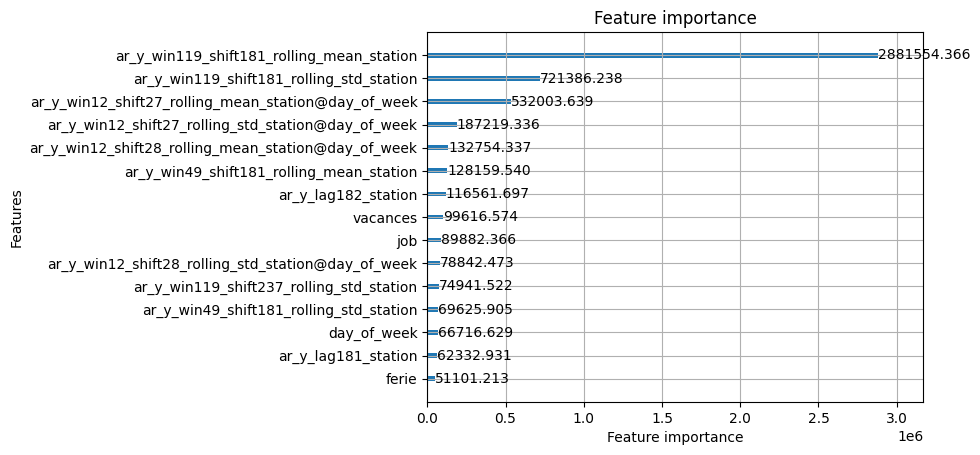

In [36]:
from copy import deepcopy

validation=False
effect_m = GBTModel(params=params_q, 
                    early_stopping_value=200, 
                    features= None,
                    custom_loss=params_q['objective'], 
                    categorical_features=[]
                    )

reconstruct_valid = []
reconstruct_test = []

left_term = train_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(1).alias('train'))
right_term = test_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(0).alias('train'))
full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
del left_term, right_term

for i, piece in enumerate(chains):
    print(f"running {piece = }")


    autoreg_dict = {
        ts_uid : {
            'groups' : ts_uid,
            'horizon': lambda horizon : np.int32(horizon),
            'wins' : np.array(win_list), 
            'shifts' : lambda horizon : np.int32([horizon, horizon+56]), 
            'lags' : lambda horizon : np.array(significant_lags) + horizon,
            'funcs' : np.array(flist)
        },
        "ts_uid_dow" : {
            'groups':[ts_uid, 'day_of_week'],
            'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
            'wins' : np.array([4, 12]), 
            'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1, np.ceil(horizon /7) + 2]), 
            'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
            'funcs' : np.array(flist)
        }
    }


    dir_forecaster = DirectForecaster(
        model=deepcopy(effect_m),
        ts_uid=ts_uid,
        forecast_range=piece,
        target_str="y",
        date_str="date",
        exogs=exog,
        features_params=autoreg_dict
    )

    dir_forecaster.fit(train_data=train_data)

    # dir_forecaster.model.save(path="out/submit/", name=f"lgb_chain_{i}")
    GBTModel.importance_plot(dir_forecaster.model.lgb_model)

    # append validation test to_evaluate model.
    reconstruct_valid.append(
        (dir_forecaster
                 .valid
                 .with_columns(pl.lit(dir_forecaster.model.predict(dir_forecaster.valid)).alias('y_hat'))
                 .select([ts_uid, date_col, 'y_hat'])
    ))

    display(
        dir_forecaster.evaluate()
    )

    if not validation:
        lgb_out = dir_forecaster.predict(full_data).filter(pl.col('train') == 0).select([ts_uid, date_col, 'y_hat'])
        #lgb_out = lgb_out.with_columns(pl.lit(np.expm1(lgb_out['y_hat'])).alias('y_hat')).select([ts_uid, date_col, "y_hat"])
        reconstruct_test.append(lgb_out)    
    del dir_forecaster

In [38]:
reconstruct_test = pl.concat(reconstruct_test, how="vertical_relaxed")
reconstruct_valid = pl.concat(reconstruct_valid, how="vertical")

out_t= (test_data[['index', 'date', 'station']]
            .to_pandas()
            .assign(date=lambda x : x['date'].astype(str))
            .merge(lgb_out.to_pandas().assign(date=lambda x : x['date'].astype(str),
                            y=lambda x : np.clip(x['y_hat'], a_min=0, a_max=None)),
                    how="left", left_on=["station", "date"], right_on=["station", "date"])
            )[["station", "date", "index", "y"]]
out_t = out_t.sort_values(by=['date', ts_uid])
out_t[y] = out_t.groupby(ts_uid)[y].transform(lambda x : x.ffill().fillna(0))
out_t[["index", "y"]].to_csv(f'chain_lgb.csv', index=False) 

# evaluate

In [39]:
base_col = [ts_uid, date_col, y, "day_of_year"]

baseline = (pl.concat((
    train_set.select(base_col).with_columns(pl.lit(1).alias('train')), 
    validation_set.select(base_col).with_columns(pl.lit(0).alias('train'))
    )
    , how="vertical_relaxed")
    .pipe(from_day_to_time_fe, time="date", frequency="day")
 .pipe(reference_shift_from_day, 
       target_col=y, 
       ts_uid=ts_uid,
       dayofyear_col="day_of_year"       )
 .filter(pl.col('train') == 0)
 .with_columns(
     pl.coalesce(
         pl.col('reference_y'), 
         pl.col('reference_y').mean().over(ts_uid),
         pl.col('reference_y').mean(),
         0
         )
))
"""
.with_columns(
    np.expm1(pl.col("reference_y").alias("reference_y")),
    np.expm1(pl.col(y).alias(y))
    )
"""

display_metrics(
    baseline[y].to_numpy(), 
    baseline["reference_y"].to_numpy()
    )

baseline = (baseline
            .join(
                valid_out.select(['station', 'date', 'y_hat']), 
                how="left", 
                on=["station", "date"]
            )
            .join(
                reconstruct_valid.rename({"y_hat":"chained_y_hat"}),
                how="left", 
                on=["station", "date"]
            )
)

metrics_df = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['reference_y'].fill_null(0).to_numpy(),
    name="baseline"
    )

metrics_df2 = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['y_hat'].fill_null(0).to_numpy(),
    name="lgb"
    )


metrics_df22 = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['chained_y_hat'].fill_null(0).to_numpy(),
    name="lgb_chains"
    )

allmet = pd.concat((metrics_df.transpose(), metrics_df2.transpose(), metrics_df22.transpose()), axis=1)
allmet.columns = allmet.iloc[0, :]

from IPython.display import display
display(allmet)

uids = baseline['station'].unique()
choice = np.random.choice(uids, (1))

"""
with log :

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4123.810547	4999.597825	5121.101499
bias	450.242163	1372.905182	1368.364562
mape	2.105475	1.154826	1.152257
wfiab	0.691066	0.650323	0.651813
mae	1359.627197	1538.938512	1532.378134

without log : 

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2512.594178	2364.075077
bias	421.788203	227.739412	235.493706
mape	2.774925	1.806896	1.947053
wfiab	0.68463	0.797759	0.806641
mae	1387.952732	890.065842	850.979446

wo log | w covid 

fname	baseline	lgb_chains
fname	baseline	lgb_chains
rmse	4139.15247	2292.385397
bias	421.788203	229.864649
mape	2.774925	2.033086
wfiab	0.68463	0.80966
mae	1387.952732	837.692923

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2150.431433	2273.18081
bias	421.788203	101.213962	159.685819
mape	2.774925	2.723164	2.632403
wfiab	0.68463	0.808726	0.807924
mae	1387.952732	841.800341	845.329485


fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4143.447587	2214.968268	2127.142468
bias	462.428658	70.666715	109.148351
mape	1.934116	1.718658	1.738316
wfiab	0.692717	0.8319	0.834986
mae	1365.34212	746.9146	733.203599

"""



fname,baseline,lgb,lgb_chains
fname,baseline,lgb,lgb_chains
rmse,4177.887448,2376.302299,2146.970857
bias,474.983637,-422.696745,-319.745687
mape,1.864171,1.878395,1.747513
wfiab,0.693535,0.815517,0.838934
mae,1384.572144,833.472845,727.677164


'\nwith log :\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4123.810547\t4999.597825\t5121.101499\nbias\t450.242163\t1372.905182\t1368.364562\nmape\t2.105475\t1.154826\t1.152257\nwfiab\t0.691066\t0.650323\t0.651813\nmae\t1359.627197\t1538.938512\t1532.378134\n\nwithout log : \n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2512.594178\t2364.075077\nbias\t421.788203\t227.739412\t235.493706\nmape\t2.774925\t1.806896\t1.947053\nwfiab\t0.68463\t0.797759\t0.806641\nmae\t1387.952732\t890.065842\t850.979446\n\nwo log | w covid \n\nfname\tbaseline\tlgb_chains\nfname\tbaseline\tlgb_chains\nrmse\t4139.15247\t2292.385397\nbias\t421.788203\t229.864649\nmape\t2.774925\t2.033086\nwfiab\t0.68463\t0.80966\nmae\t1387.952732\t837.692923\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2150.431433\t2273.18081\nbias\t421.788203\t101.213962\t159.685819\nmape\t2.774925\t2.723164\t2.632403\nwfiab\t

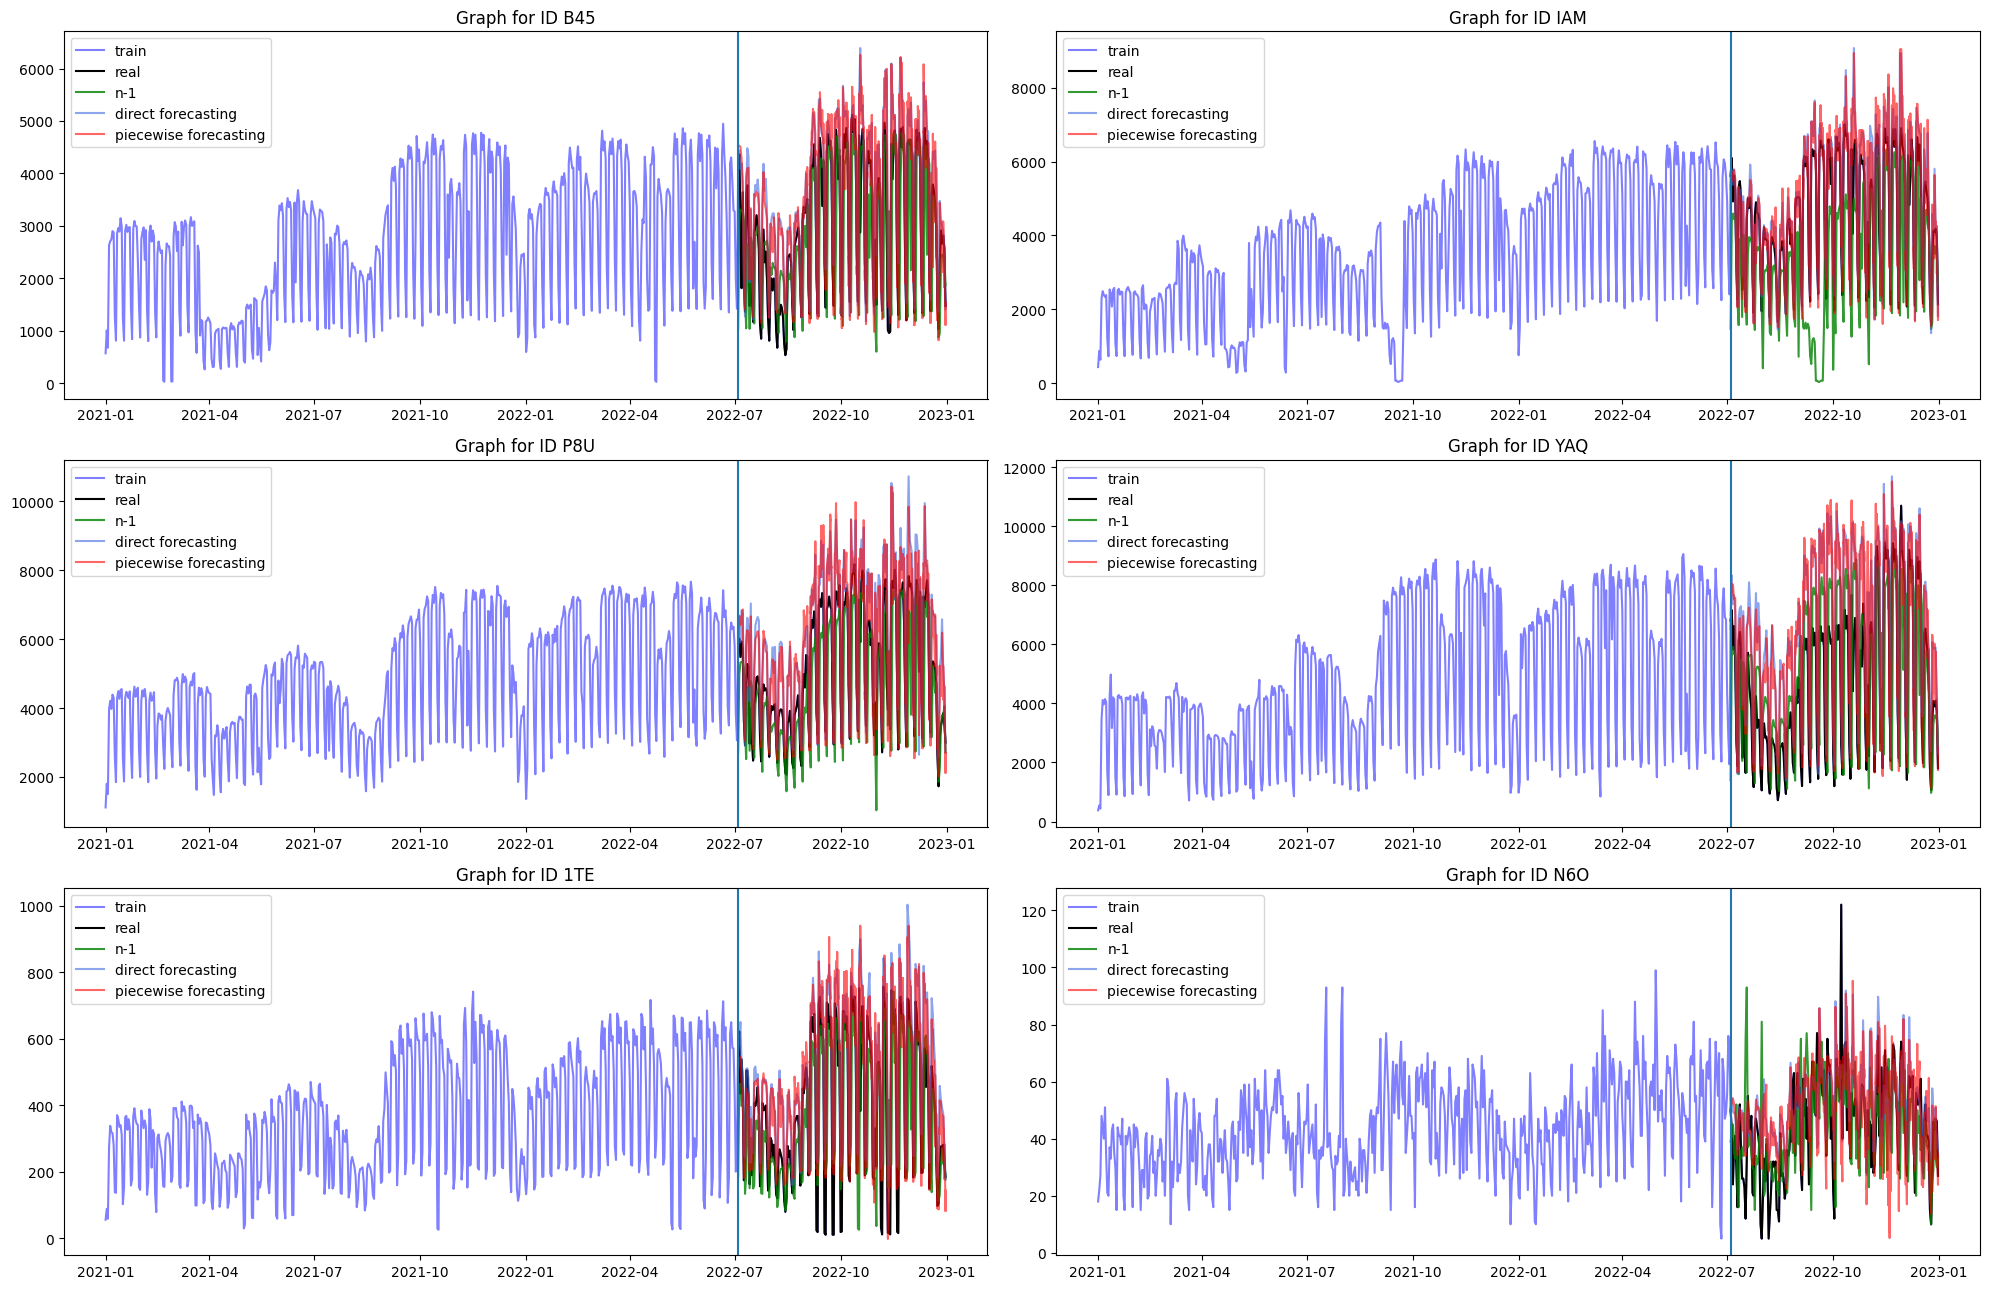

In [40]:
import matplotlib.pyplot as plt 

uids = baseline['station'].unique()
n = 6
choice = np.random.choice(uids, (n, ))

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(20, 13))
axs = axs.ravel()  # Aplatir le tableau 2D des axes pour itération facile

# Tracer les graphiques
for i, uid in enumerate(uids, start=0):
    if i  < n :
        subset_tr = train_data.filter(
            pl.col(ts_uid) == uid, pl.col('date') >= pl.datetime(2021, 1, 1)
            ).sort(by='date')
        subset = baseline.filter(pl.col(ts_uid) == uid).sort(by='date')
        axs[i].plot(subset_tr["date"], subset_tr['y_copy'], label="train", color="blue", alpha=0.5)
        axs[i].plot(subset["date"], subset['y'], label="real", color="black")
        axs[i].plot(subset["date"], subset['reference_y'], label="n-1", alpha=0.8, color="green")
        axs[i].plot(subset["date"], subset['y_hat'], label="direct forecasting", alpha=0.6, color="royalblue")
        axs[i].plot(subset["date"], subset['chained_y_hat'], label="piecewise forecasting", alpha=0.6, color="red")
        axs[i].axvline(subset['date'].min())
        axs[i].set_title(f'Graph for ID {uid}')
        axs[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

In [55]:
[ x for x in significant_lags

[0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 11,
 13,
 14,
 15,
 17,
 19,
 22,
 29,
 38,
 45,
 46,
 49,
 50,
 54,
 59,
 76,
 80,
 85,
 92,
 106,
 119,
 130,
 132,
 145,
 158,
 169,
 197,
 206,
 208,
 220,
 229,
 232,
 239,
 256,
 265,
 284,
 288,
 293,
 297,
 304,
 306,
 316,
 323,
 329,
 331,
 332,
 334,
 346,
 349,
 352,
 353,
 354,
 358,
 361]

In [61]:
from copy import deepcopy

validation=False
effect_m = GBTModel(params=params_q, 
                    early_stopping_value=200, 
                    features= None,
                    custom_loss=params_q['objective'], 
                    categorical_features=[]
                    )

reconstruct_valid = []
reconstruct_test = []

left_term = train_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(1).alias('train'))
right_term = test_data.select(["date", "station", "y"]+exog).with_columns(pl.lit(0).alias('train'))
full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
del left_term, right_term



for i, piece in enumerate(chains):
    print(f"running {piece = }")

    chain_lags = [x for x in significant_lags if x <= max(piece)]
    chain_win =  [ x for x in significant_lags if x % 7 == 0 and x <= max(piece)][1:] 

    autoreg_dict = {
        ts_uid : {
            'groups' : ts_uid,
            'horizon': lambda horizon : np.int32(horizon),
            'wins' : np.array(win_list), 
            'shifts' : lambda horizon : np.int32([horizon]), 
            'lags' : lambda horizon : np.array(chain_lags) + horizon,
            'funcs' : np.array(flist)
        },
        "ts_uid_dow" : {
            'groups':[ts_uid, 'day_of_week'],
            'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
            'wins' : np.array([4]), 
            'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1]), 
            'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
            'funcs' : np.array(flist)
        }
    }


    dir_forecaster = DirectForecaster(
        model=deepcopy(effect_m),
        ts_uid=ts_uid,
        forecast_range=piece,
        target_str="y",
        date_str="date",
        exogs=exog,
        features_params=autoreg_dict
    )

    dir_forecaster.fit(train_data=train_data, strategy="local")

    # dir_forecaster.model.save(path="out/submit/", name=f"lgb_chain_{i}")
    # GBTModel.importance_plot(dir_forecaster.model.lgb_model)

    # append validation test to_evaluate model.
    reconstruct_valid.append(dir_forecaster.predict_local(dir_forecaster.valid).select([ts_uid, date_col, 'y_hat']))
    display(
        dir_forecaster.evaluate()
    )
    if not validation:
        lgb_out = dir_forecaster.predict(full_data).filter(pl.col('train') == 0).select([ts_uid, date_col, 'y_hat'])
        #lgb_out = lgb_out.with_columns(pl.lit(np.expm1(lgb_out['y_hat'])).alias('y_hat')).select([ts_uid, date_col, "y_hat"])
        reconstruct_test.append(lgb_out)    
    del dir_forecaster

running piece = array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])


426it [01:06,  6.42it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,12228.167939,1581.877533,11.67663,-0.12503,4922.83264


The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('OWM',)
The following uids cannot be forecasted. : ('92P',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('J9C',)
The following uids cannot be forecasted. : ('P6E',)
The following uids cannot be forecasted. : ('W14',)
The following uids cannot be forecasted. : ('VV4',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('L58',)
running piece = array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])


426it [01:03,  6.67it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,12647.965908,1709.40147,14.360205,-0.154577,5324.647723


The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('VV4',)
The following uids cannot be forecasted. : ('OWM',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('L58',)
The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('J9C',)
The following uids cannot be forecasted. : ('P6E',)
The following uids cannot be forecasted. : ('92P',)
The following uids cannot be forecasted. : ('W14',)
running piece = array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])


426it [00:57,  7.39it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,13301.954479,1646.216973,15.717512,-0.169521,5502.797422


The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('92P',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('L58',)
The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('J9C',)
The following uids cannot be forecasted. : ('VV4',)
The following uids cannot be forecasted. : ('W14',)
The following uids cannot be forecasted. : ('P6E',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('OWM',)
running piece = array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120])


426it [00:57,  7.47it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,13522.451217,1341.162325,14.50061,-0.213514,5728.416225


The following uids cannot be forecasted. : ('QD6',)
The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('W14',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('OWM',)
The following uids cannot be forecasted. : ('P6E',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('L58',)
The following uids cannot be forecasted. : ('VV4',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('92P',)
The following uids cannot be forecasted. : ('J9C',)
running piece = array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150])


426it [01:00,  7.08it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,12620.137075,1172.089827,18.269775,-0.211382,5376.779988


The following uids cannot be forecasted. : ('QD6',)
The following uids cannot be forecasted. : ('92P',)
The following uids cannot be forecasted. : ('OWM',)
The following uids cannot be forecasted. : ('L58',)
The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('P6E',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('W14',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('VV4',)
running piece = array([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180])


426it [00:54,  7.78it/s]


,fname,rmse,bias,mape,wfiab,mae
0,default,11639.50536,892.898878,21.576974,-0.173683,5099.417431


The following uids cannot be forecasted. : ('W14',)
The following uids cannot be forecasted. : ('TPX',)
The following uids cannot be forecasted. : ('EFN',)
The following uids cannot be forecasted. : ('P6E',)The following uids cannot be forecasted. : ('92P',)

The following uids cannot be forecasted. : ('VV4',)
The following uids cannot be forecasted. : ('OWM',)
The following uids cannot be forecasted. : ('B9M',)
The following uids cannot be forecasted. : ('L58',)
The following uids cannot be forecasted. : ('W80',)
The following uids cannot be forecasted. : ('BDC',)
The following uids cannot be forecasted. : ('QD6',)
The following uids cannot be forecasted. : ('J9C',)


In [64]:
reconstruct_test = pl.concat(reconstruct_test, how="vertical_relaxed")
reconstruct_valid = pl.concat(reconstruct_valid, how="vertical")

out_t= (test_data[['index', 'date', 'station']]
            .to_pandas()
            .assign(date=lambda x : x['date'].astype(str))
            .merge(lgb_out.to_pandas().assign(date=lambda x : x['date'].astype(str),
                            y=lambda x : np.clip(x['y_hat'], a_min=0, a_max=None)),
                    how="left", left_on=["station", "date"], right_on=["station", "date"])
            )[["station", "date", "index", "y"]]
out_t = out_t.sort_values(by=['date', ts_uid])
out_t[y] = out_t.groupby(ts_uid)[y].transform(lambda x : x.ffill().fillna(0))
out_t[["index", "y"]].to_csv(f'out/submit/local_chain_lgb.csv', index=False) 

ValueError: Series only supports 'vertical' concat strategy

In [65]:
base_col = [ts_uid, date_col, y, "day_of_year"]

baseline = (pl.concat((
    train_set.select(base_col).with_columns(pl.lit(1).alias('train')), 
    validation_set.select(base_col).with_columns(pl.lit(0).alias('train'))
    )
    , how="vertical_relaxed")
    .pipe(from_day_to_time_fe, time="date", frequency="day")
 .pipe(reference_shift_from_day, 
       target_col=y, 
       ts_uid=ts_uid,
       dayofyear_col="day_of_year"       )
 .filter(pl.col('train') == 0)
 .with_columns(
     pl.coalesce(
         pl.col('reference_y'), 
         pl.col('reference_y').mean().over(ts_uid),
         pl.col('reference_y').mean(),
         0
         )
))
"""
.with_columns(
    np.expm1(pl.col("reference_y").alias("reference_y")),
    np.expm1(pl.col(y).alias(y))
    )
"""

display_metrics(
    baseline[y].to_numpy(), 
    baseline["reference_y"].to_numpy()
    )

baseline = (baseline
            .join(
                valid_out.select(['station', 'date', 'y_hat']), 
                how="left", 
                on=["station", "date"]
            )
            .join(
                reconstruct_valid.rename({"y_hat":"chained_y_hat"}),
                how="left", 
                on=["station", "date"]
            )
)

metrics_df = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['reference_y'].fill_null(0).to_numpy(),
    name="baseline"
    )

metrics_df2 = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['y_hat'].fill_null(0).to_numpy(),
    name="lgb"
    )


metrics_df22 = display_metrics(
    baseline[y].fill_null(0).to_numpy(), 
    baseline['chained_y_hat'].fill_null(0).to_numpy(),
    name="lgb_chains"
    )

allmet = pd.concat((metrics_df.transpose(), metrics_df2.transpose(), metrics_df22.transpose()), axis=1)
allmet.columns = allmet.iloc[0, :]

from IPython.display import display
display(allmet)

uids = baseline['station'].unique()
choice = np.random.choice(uids, (1))

"""
with log :

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4123.810547	4999.597825	5121.101499
bias	450.242163	1372.905182	1368.364562
mape	2.105475	1.154826	1.152257
wfiab	0.691066	0.650323	0.651813
mae	1359.627197	1538.938512	1532.378134

without log : 

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2512.594178	2364.075077
bias	421.788203	227.739412	235.493706
mape	2.774925	1.806896	1.947053
wfiab	0.68463	0.797759	0.806641
mae	1387.952732	890.065842	850.979446

wo log | w covid 

fname	baseline	lgb_chains
fname	baseline	lgb_chains
rmse	4139.15247	2292.385397
bias	421.788203	229.864649
mape	2.774925	2.033086
wfiab	0.68463	0.80966
mae	1387.952732	837.692923

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2150.431433	2273.18081
bias	421.788203	101.213962	159.685819
mape	2.774925	2.723164	2.632403
wfiab	0.68463	0.808726	0.807924
mae	1387.952732	841.800341	845.329485


fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4143.447587	2214.968268	2127.142468
bias	462.428658	70.666715	109.148351
mape	1.934116	1.718658	1.738316
wfiab	0.692717	0.8319	0.834986
mae	1365.34212	746.9146	733.203599

global chain

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4177.887448	2376.302299	2146.970857
bias	474.983637	-422.696745	-319.745687
mape	1.864171	1.878395	1.747513
wfiab	0.693535	0.815517	0.838934
mae	1384.572144	833.472845	727.677164

"""



fname,baseline,lgb,lgb_chains
fname,baseline,lgb,lgb_chains
rmse,4177.887448,2376.302299,12399.409007
bias,474.983637,-422.696745,1265.511702
mape,1.864171,1.878395,13.168356
wfiab,0.693535,0.815517,-0.105962
mae,1384.572144,833.472845,4996.602873


'\nwith log :\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4123.810547\t4999.597825\t5121.101499\nbias\t450.242163\t1372.905182\t1368.364562\nmape\t2.105475\t1.154826\t1.152257\nwfiab\t0.691066\t0.650323\t0.651813\nmae\t1359.627197\t1538.938512\t1532.378134\n\nwithout log : \n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2512.594178\t2364.075077\nbias\t421.788203\t227.739412\t235.493706\nmape\t2.774925\t1.806896\t1.947053\nwfiab\t0.68463\t0.797759\t0.806641\nmae\t1387.952732\t890.065842\t850.979446\n\nwo log | w covid \n\nfname\tbaseline\tlgb_chains\nfname\tbaseline\tlgb_chains\nrmse\t4139.15247\t2292.385397\nbias\t421.788203\t229.864649\nmape\t2.774925\t2.033086\nwfiab\t0.68463\t0.80966\nmae\t1387.952732\t837.692923\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2150.431433\t2273.18081\nbias\t421.788203\t101.213962\t159.685819\nmape\t2.774925\t2.723164\t2.632403\nwfiab\t

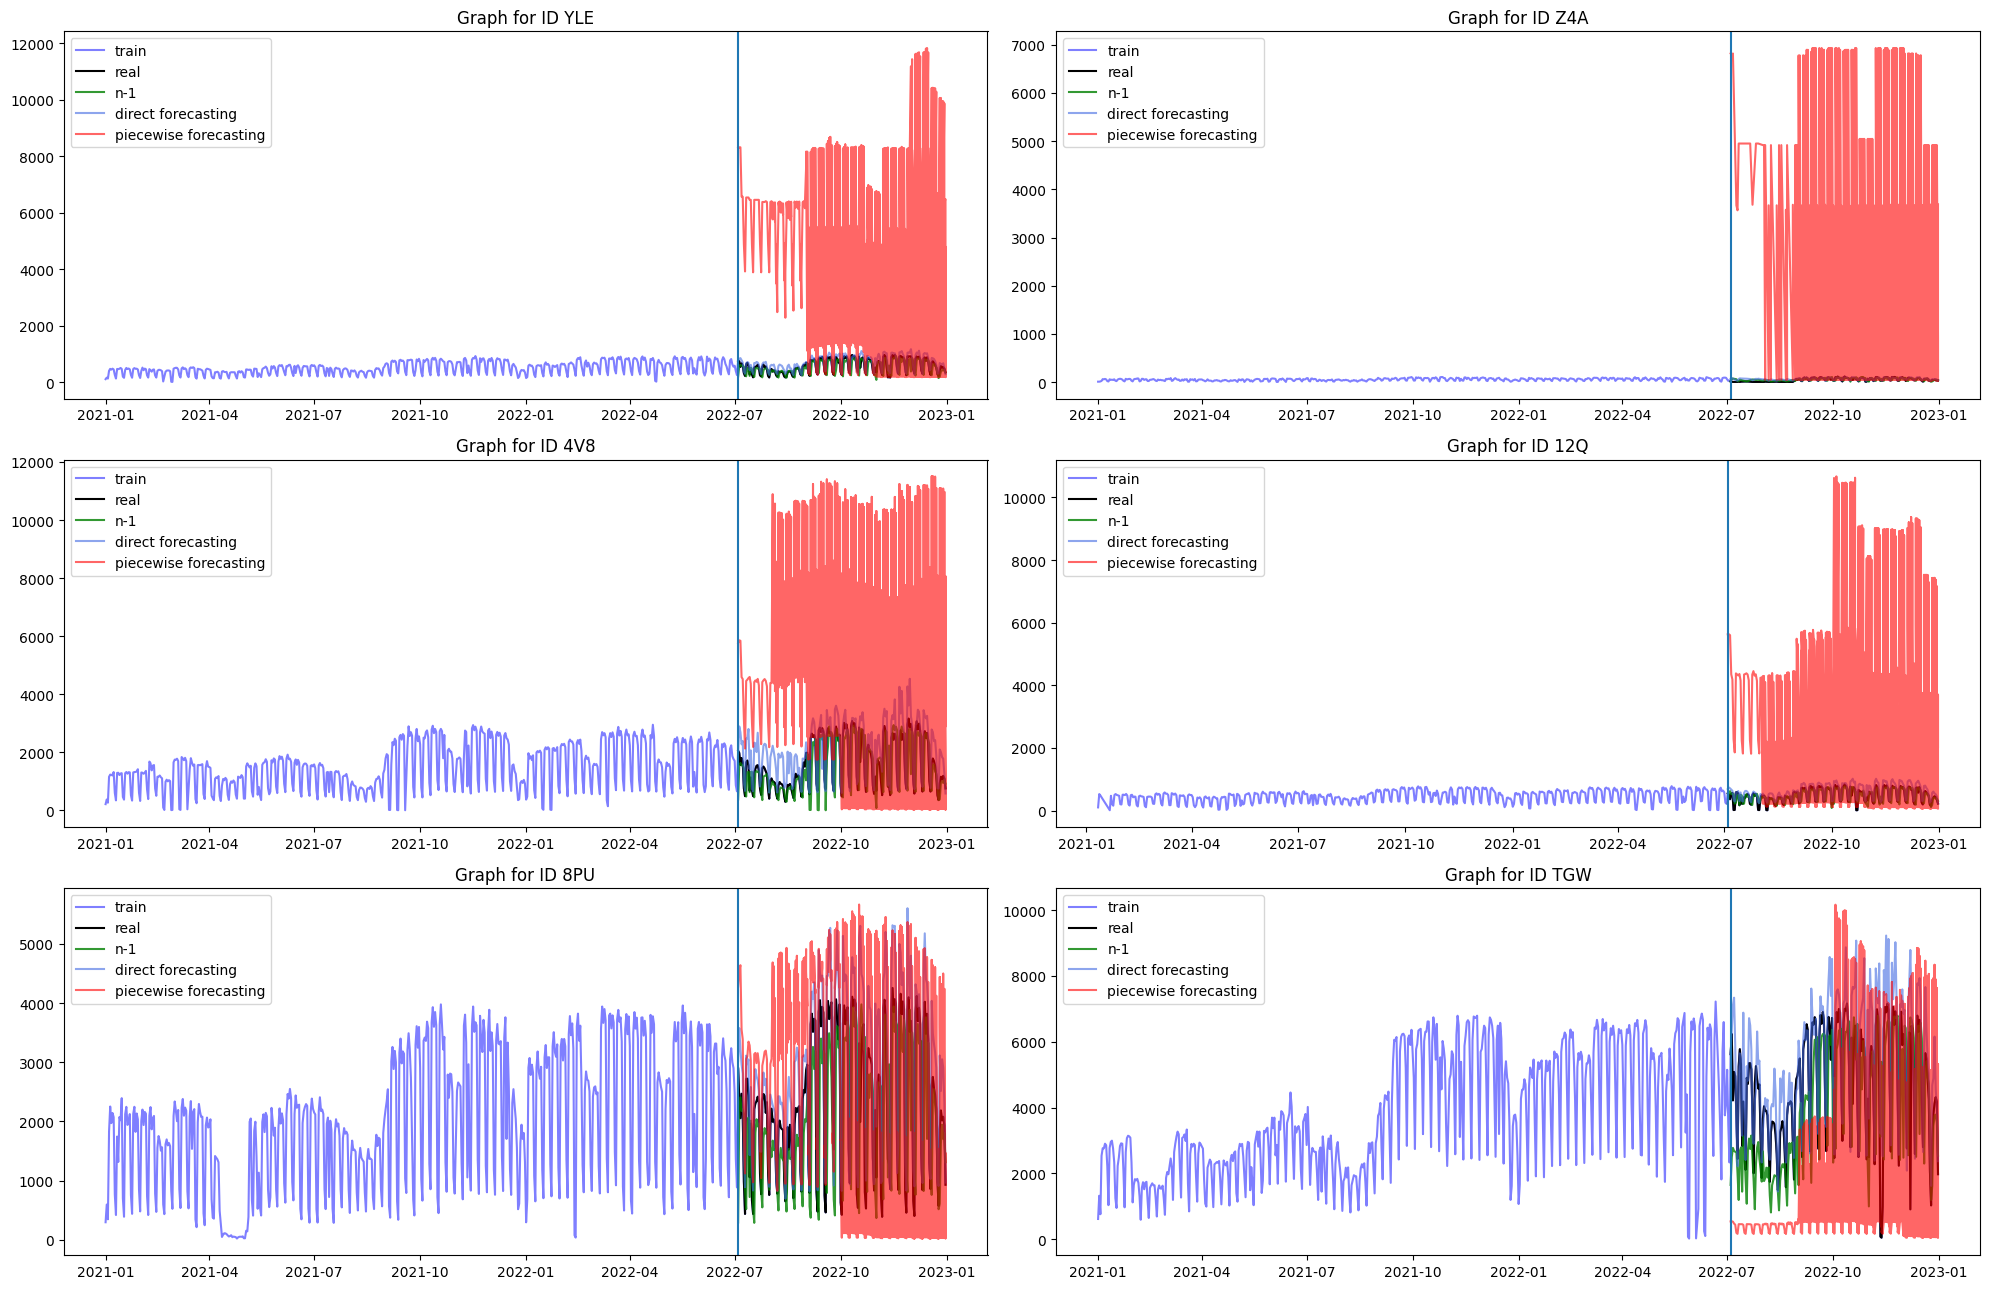

In [70]:
import matplotlib.pyplot as plt 

uids = baseline['station'].unique()
n = 6
choice = np.random.choice(uids, (n, ))

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(20, 13))
axs = axs.ravel()  # Aplatir le tableau 2D des axes pour itération facile

# Tracer les graphiques
for i, uid in enumerate(uids, start=0):
    if i  < n :
        subset_tr = train_data.filter(
            pl.col(ts_uid) == uid, pl.col('date') >= pl.datetime(2021, 1, 1)
            ).sort(by='date')
        subset = baseline.filter(pl.col(ts_uid) == uid).sort(by='date')
        axs[i].plot(subset_tr["date"], subset_tr['y_copy'], label="train", color="blue", alpha=0.5)
        axs[i].plot(subset["date"], subset['y'], label="real", color="black")
        axs[i].plot(subset["date"], subset['reference_y'], label="n-1", alpha=0.8, color="green")
        axs[i].plot(subset["date"], subset['y_hat'], label="direct forecasting", alpha=0.6, color="royalblue")
        axs[i].plot(subset["date"], subset['chained_y_hat'], label="piecewise forecasting", alpha=0.6, color="red")
        axs[i].axvline(subset['date'].min())
        axs[i].set_title(f'Graph for ID {uid}')
        axs[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()